<a href="https://colab.research.google.com/github/JackBstn/NLP/blob/main/chronos_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Trading Simulation

This Colab notebook implements a trading strategy that leverages our pre-trained neural network for stock price predictio (remember that the *goal of the neural network* is to join the predictions made by the Chronos model for each dimension into a single prediction for the next day's closing price). The objective is to use these predictions to make trading decisions and compare the performance against a traditional Buy & Hold strategy. Trading decisions (BUY, SELL, HOLD) are based on the predicted percentage change in price. The strategy's portfolio value is compared against a Buy & Hold benchmark.

#### Model & Data
- Data Source: Historical stock data retrieved from Yahoo Finance.
- Features Used: Open, High, Low, Volume, and Close prices.

#### Trading Logic

1. Decision-Making Rules
   - If the predicted price is at least 0.1% higher than the current price → *BUY* (if capital is available).
   - If the predicted price is at least 0.1% lower than the current price → *SELL* (if shares are held).
   - Otherwise, *HOLD* the position.

2. Portfolio Update: The portfolio value is updated daily, considering both cash and held shares.

#### Final Evaluation
At the end of the simulation:
- The total portfolio value is computed.
- A performance comparison is made against the Buy & Hold strategy.


### Install Dependencies

In [1]:
!pip install torch transformers chronos yfinance pandas matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git
!git clone https://github.com/JackBstn/NLP.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.3 MB/s eta 0:00:00
  Created wheel for chronos: filename=chronos-0.3-py3-none-any.whl size=7374 sha256=eb8870adbe8386da6f059786c5fa4e5948258270fbf92e7daa9cbf86d43afa9e
  Stored in di

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, TensorDataset

seed = 343126


def reset_seed():
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#### Import NN pre-trained model

In [3]:
class PricePredictionNN(nn.Module):
    """
    Neural Network for price prediction.
    Architecture: 3 fully connected layers with ReLU activation and dropout.
    """

    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(PricePredictionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(hidden_size_2, output_size)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [4]:
reset_seed()  # For reproducibility

# Model
input_size = 5  # Feature number
hidden_size_1 = 128  # Number of hidden units in first hidden layer
hidden_size_2 = 64  # Number of hidden units in second hidden layer
output_size = 1  # Output size (1 for regression)
scaler_x = StandardScaler()
scaler_y = StandardScaler()
model = PricePredictionNN(input_size, hidden_size_1, hidden_size_2, output_size)

# Load the trained model
model.load_state_dict(torch.load("NLP/models/nn_model.pth"))
model.eval()

<ipython-input-4-1ce6de44ca35>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("NLP/models/nn_model.pth"))


PricePredictionNN(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

#### Download test data

In [5]:
# Download Yahoo Finance data
symbol = "AAPL"
test_data = yf.download(symbol, start="2024-01-01", end="2024-03-31", progress=False)

# Prepare the dataset: extract features and closing prices
test_features = test_data[["Open", "High", "Low", "Volume", "Close"]].values
test_close_prices = test_data["Close"].values

# Recover training scaler
data = np.load("NLP/models/chronos_dataset_nn.npz")
X_training = data["X"]
Y_training = data["Y"]
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X_training)
scaler_y = StandardScaler()
Y = scaler_y.fit_transform(Y_training)

# Normalize the features using the scaler applied during training
X_test_scaled = scaler_x.transform(test_features)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

### Trading bot

Day 0: Actual Price = [184.73497009]€, Predicted Price = 184.23947655839683€, Diff = [-0.26821859]%, Action = HOLD
Day 1: Actual Price = [183.35176086]€, Predicted Price = 182.88627148037722€, Diff = [-0.25387778]%, Action = HOLD
Day 2: Actual Price = [181.02316284]€, Predicted Price = 180.52555632368777€, Diff = [-0.27488555]%, Action = HOLD
Day 3: Actual Price = [180.29670715]€, Predicted Price = 180.01107208714294€, Diff = [-0.158425]%, Action = HOLD
Day 4: Actual Price = [184.65536499]€, Predicted Price = 182.3046535030701€, Diff = [-1.27302637]%, Action = HOLD
Day 5: Actual Price = [184.2374115]€, Predicted Price = 182.83521164198632€, Diff = [-0.76108313]%, Action = HOLD
Day 6: Actual Price = [185.2822876]€, Predicted Price = 183.78805453783866€, Diff = [-0.80646298]%, Action = HOLD
Day 7: Actual Price = [184.68522644]€, Predicted Price = 184.10206591279476€, Diff = [-0.31575916]%, Action = HOLD
Day 8: Actual Price = [185.01361084]€, Predicted Price = 184.46875512621543€, Diff = 

<ipython-input-6-db81fe9f1d61>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shares_to_buy = int(budget // current_price)
<ipython-input-6-db81fe9f1d61>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shares_to_buy = int(budget // current_price)
<ipython-input-6-db81fe9f1d61>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shares_to_buy = int(budget // current_price)
<ipython-input-6-db81fe9f1d61>:35: DeprecationWarning: Conversion of an array with ndim > 0

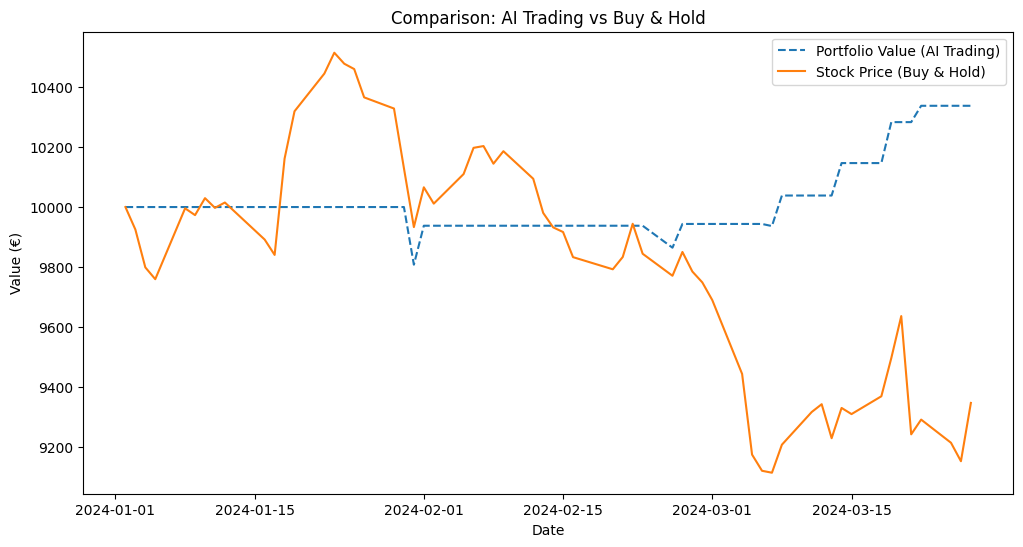

In [6]:
reset_seed()  # For reproducibility

# Initialize capital and variables for the simulation
budget = 10000.0       # Initial capital in €
shares_held = 0        # Number of shares currently held
portfolio_values = []  # List to store daily portfolio value
actions_taken = []     # List to record trading decisions (BUY, SELL, HOLD)

# Percentage threshold to trigger a trade
threshold_percent = 0.1

# Simulation loop: iterate from the first day to the second-to-last (to have a "tomorrow" price)
for i in range(len(X_test) - 1):
    current_price = test_close_prices[i]

    # Predict the price for the next trading day
    with torch.no_grad():
        # The model expects an input of shape (1, 5)
        predicted_price_scaled = model(X_test[i].unsqueeze(0)).item()

    # Convert the predicted price back to the original scale
    predicted_price = scaler_y.inverse_transform([[predicted_price_scaled]])[0, 0]

    # Compute the percentage difference between the predicted and actual price
    percent_diff = ((predicted_price - current_price) / current_price) * 100

    # Default decision is HOLD
    decision = "HOLD"

    # Trading strategy:
    # - If the predicted price is at least threshold% higher than the current price, buy
    # - If the predicted price is at least threshold% lower than the current price, sell (if shares are held)
    if percent_diff > threshold_percent and budget >= current_price:
        # Buy as many shares as possible with the available budget
        shares_to_buy = int(budget // current_price)
        budget -= shares_to_buy * current_price
        shares_held += shares_to_buy
        decision = "BUY"
    elif percent_diff < -threshold_percent and shares_held > 0:
        # Sell all currently held shares
        budget += shares_held * current_price
        shares_held = 0
        decision = "SELL"

    actions_taken.append(decision)
    # Compute the current portfolio value (cash + value of held shares)
    portfolio_value = budget + (shares_held * current_price)
    portfolio_values.append(portfolio_value)

    # Print daily trading details
    print(f"Day {i}: Actual Price = {current_price}€, Predicted Price = {predicted_price}€, Diff = {percent_diff}%, Action = {decision}")

# Final portfolio value at the end of the simulation period
final_value = budget + (shares_held * test_close_prices[-1])
print(f"\nFinal Portfolio Value: {final_value}€")

# Plot the portfolio value over time and compare it to a Buy & Hold strategy
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[:-1], portfolio_values, label="Portfolio Value (AI Trading)", linestyle="dashed")

# Buy & Hold strategy: Assume all capital was invested on the first day
buy_hold_values = test_close_prices[:-1] * (10000 / test_close_prices[0])
plt.plot(test_data.index[:-1], buy_hold_values, label="Stock Price (Buy & Hold)")

plt.xlabel("Date")
plt.ylabel("Value (€)")
plt.title("Comparison: AI Trading vs Buy & Hold")
plt.legend()
plt.show()